
<h1> <center> Trade data analysis: Canada exports and imports - Part 1 </center> </h1>
<p style="color:black;font-size:18px;">
   Part 1 of the analysis on the <a href="https://open.canada.ca/data/en/dataset/c2231d1e-0b04-4c8c-9d36-46f67cece549" target="_top"> Public dataset> </a> on merchandise imports and exports from Canadian provinces to the United states. 
</p>

In [16]:
import numpy as np
import pandas as pd
import os
import datetime
from matplotlib import pyplot as plt
from matplotlib.legend import Legend
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import requests, zipfile, io

%matplotlib inline
%reload_ext autoreload

In [31]:
# load data
data_uri_zip = "https://www150.statcan.gc.ca/n1/tbl/csv/12100099-eng.zip"
datafile = "12100099.csv"
usecols = ["REF_DATE","GEO","Trade","United States","Harmonized System (HS) Sections","VALUE"]
nrows = 1000
r = requests.get(data_uri_zip, stream=True)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    with z.open(datafile) as f:
        df = pd.read_csv(f, header=0,usecols=usecols)

In [33]:
# preprocessing step 1
# Change columns names to simple ones
old_colnames = ["REF_DATE","GEO","Trade","United States","Harmonized System (HS) Sections","VALUE"]
new_colnames = ["Date","Canada","Trade","USA","HS","Value"]
df.rename(columns = dict(zip(old_colnames,new_colnames)),inplace=True)

In [36]:
# convert "REF_DATE" to datetime object
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
# conver value to millions
df["Value"] = df["Value"]/1E6

In [37]:
df.head()

,Date,Canada,Trade,USA,HS,Value,Month,Year
0,1990-01-01,Canada,Total exports,Total United States,Total Harmonized System (HS) sections,8.462567,1,1990
1,1990-01-01,Canada,Total exports,Total United States,I - Live animals and animal products,0.211653,1,1990
2,1990-01-01,Canada,Total exports,Total United States,II - Vegetable products,0.082447,1,1990
3,1990-01-01,Canada,Total exports,Total United States,III - Animal or vegetable fats and oils and th...,0.006821,1,1990
4,1990-01-01,Canada,Total exports,Total United States,"IV - Prepared foodstuffs, beverages, spirits a...",0.138902,1,1990


Text(0.5, 0, '')

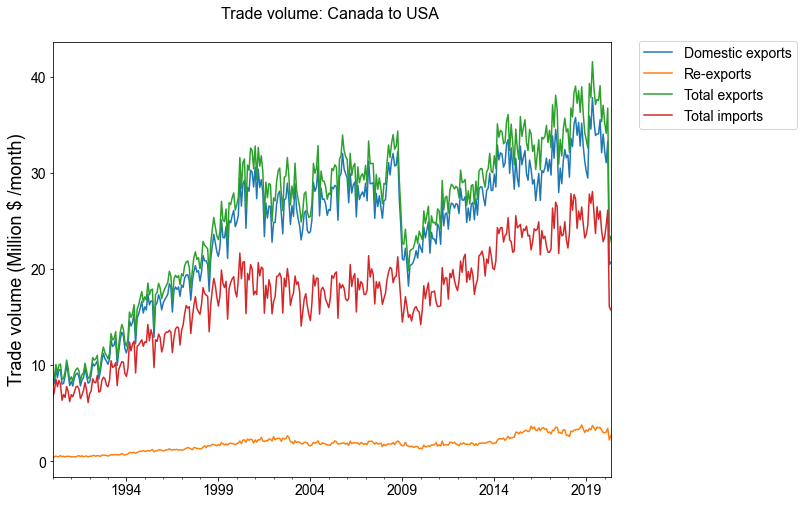

In [114]:
# plot exports and imports from canada to USA from 1990 to 2020
# create mask to subset only whole Canada trades to USA on all sections
mask = ((df["Canada"]== "Canada") & (df["USA"] == "Total United States") &
             (df["HS"] == "Total Harmonized System (HS) sections"))
dfcan = df[mask].copy().reset_index().loc[:,["Trade","Year","Month","Date","Value"]]
# create multi-index from Date and Trade
dfcan.set_index(["Date","Trade"],inplace=True)
dfcanw = dfcan["Value"].unstack(level=-1)
dfcanw.resample(rule="A").mean()
fh = plt.figure(figsize=(10,8))
ah = fh.add_subplot(111)
dfcanw.plot(ax=ah)
ah.legend(loc=(1.05,0.8), prop={'size': 14})
ah.tick_params(axis="x", labelsize=14)
ah.tick_params(axis="y", labelsize=14)
ah.set_title("Trade volume: Canada to USA \n",fontsize=16)
ah.set_ylabel('Trade volume (Million $ /month)', fontsize=18)
ah.set_xlabel(None, fontsize=12)

From the above figure, we can see that trade volume of Canada increased steadily from mid 1990's, a trend that continued to 2000. After 2000, there was a slight reduction in trade volume and was followed by plateauing. We can also notice the the sharp decline of trade volumes due to the market recession in 2007-08. Markets in Canada witnessed yet another growth phase in the economy until the impact of COVID in early 2020.

Index(['Domestic exports', 'Re-exports', 'Total exports', 'Total imports',
       'Cycle Total exports', 'Trend Total exports', 'Cycle Domestic exports',
       'Trend Domestic exports', 'Cycle Re-exports', 'Trend Re-exports',
       'Cycle Total imports', 'Trend Total imports'],
      dtype='object', name='Trade')
['Total exports', 'Trend Total exports', 'Cycle Total exports']
['Domestic exports', 'Trend Domestic exports', 'Cycle Domestic exports']
['Re-exports', 'Trend Re-exports', 'Cycle Re-exports']
['Total imports', 'Trend Total imports', 'Cycle Total imports']


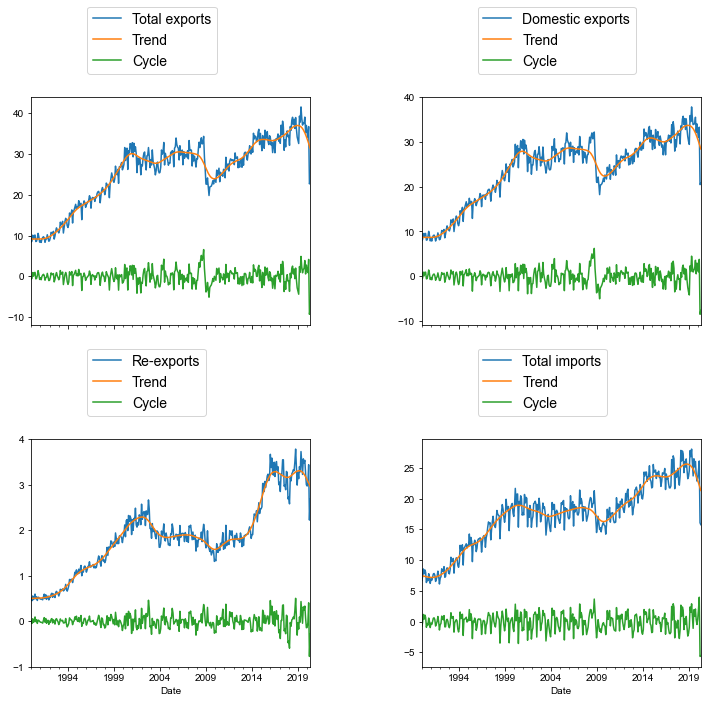

In [140]:
# Hodrick-Prescott filter to get the trend of the data: 
trades = dfcan.index.get_level_values(1).unique().values
dfcanwf = dfcanw.copy()
for trade in trades:
    cycle,trend = sm.tsa.filters.hpfilter(dfcanw[trade])
    dfcanwf["Cycle "+trade] = cycle
    dfcanwf["Trend "+trade] = trend
print(dfcanwf.columns)
fh, ah = plt.subplots(2, 2, sharex='col',figsize=(12,8))
plt.subplots_adjust(top = 1, bottom=0.01, hspace=0.5, wspace=0.4)
count = 0
for i in range(2):
    for j in range(2):
        trade = trades[count]
        columns = [trade,"Trend "+trade,"Cycle "+trade]
        print(columns)
        dfcanwf[columns].plot(ax=ah[i,j])
        ah[i,j].legend([trade,"Trend","Cycle"],loc=(0.2,1.1), prop={'size': 14})
        count = count + 1